This notebook uses the previously obtained similarities between lyrics to make groups of duplicated lyrics.

In [ ]:
# mount GDrive
from google.colab import drive
#drive.mount('/content/drive')
drive._mount('/content/drive')

Mounted at /content/drive


In [ ]:
# load dataset_10
!cp -r "drive/MyDrive/Artistic_Content_Creation/WASABI_gender_experiments/WASABI_gender_experiments_definitive/dataset_10/data_lyrics_group_decades" .
!cp -r "drive/MyDrive/Artistic_Content_Creation/WASABI_gender_experiments/WASABI_gender_experiments_definitive/dataset_10/data_lyrics_person_decades" .

# load results of duplicate detection
!cp -r "drive/MyDrive/Artistic_Content_Creation/WASABI_gender_experiments/WASABI_gender_experiments_definitive/dataset_10/duplicate_detection" . 


In [ ]:
%pylab inline
import pandas as pd
import networkx as nx
import glob

from scipy.special import binom

from tqdm.notebook import tqdm
tqdm.pandas()

Populating the interactive namespace from numpy and matplotlib


In [ ]:
# get number of songs across time
data_folders = ['data_lyrics_person_decades/', 'data_lyrics_group_decades/']

song_lyrics = []

for data_folder in data_folders:
    type_ = data_folder.split('_')[-2]
    for file in glob.glob(data_folder+'*_[!.]*.json.gz'): # skip songs with no dates

        data_chunk = pd.read_json(file, orient='records', lines=True, chunksize=5000 )
        for chunk in data_chunk:        

            chunk = chunk[['song_id', 'song_title', 'language_detect', 'lyrics', 'n_words', 'n_lines', 'artist_id', 'artist_name',
                            'song_pubdate_combined', 'song_year_combined', 'song_decade_combined', 'other_artist_info']]
            song_lyrics.append(chunk)

song_lyrics = pd.concat(song_lyrics)
print('Total number of song lyrics: ', song_lyrics.shape[0])
song_lyrics.head()

Total number of song lyrics:  460339


,song_id,song_title,language_detect,lyrics,n_words,n_lines,artist_id,artist_name,song_pubdate_combined,song_year_combined,song_decade_combined,other_artist_info
0,5714dec325ac0d8aee380b13,Tears All Over Town,english,Ride the subway home\nPretend that you're not ...,192,33,56d7e9416b60c09814f93eb7,A Girl Called Eddy,2004-08-10,2004,2000,"{'n_albums': 2, 'n_songs': 16, 'languages': {'..."
1,5714dec325ac0d8aee380b14,Kathleen,english,If I don't laugh i'll cry\nAt all the years go...,201,39,56d7e9416b60c09814f93eb7,A Girl Called Eddy,2004-08-10,2004,2000,"{'n_albums': 2, 'n_songs': 16, 'languages': {'..."
2,5714dec325ac0d8aee380b15,Girls Can Really Tear You Up Inside,english,There's a girl whose stuck inside a picture fr...,233,38,56d7e9416b60c09814f93eb7,A Girl Called Eddy,2004-08-10,2004,2000,"{'n_albums': 2, 'n_songs': 16, 'languages': {'..."
3,5714dec325ac0d8aee380b16,The Long Goodbye,english,You stormed my winter palace\nYou rid my heart...,202,36,56d7e9416b60c09814f93eb7,A Girl Called Eddy,2004-08-10,2004,2000,"{'n_albums': 2, 'n_songs': 16, 'languages': {'..."
4,5714dec325ac0d8aee380b17,Somebody Hurt You,english,Boy\nSomebody hurt you\nBoy\nI wish I knew who...,210,42,56d7e9416b60c09814f93eb7,A Girl Called Eddy,2004-08-10,2004,2000,"{'n_albums': 2, 'n_songs': 16, 'languages': {'..."


In [ ]:
# remove exact duplicates. How may unique?
# we will add them to the cliques
exact_duplicated_lyrics = song_lyrics[song_lyrics.lyrics.duplicated(False)]
song_lyrics = song_lyrics.sort_values("song_year_combined").drop_duplicates(subset=['lyrics'], keep='first')

print('N lyrics: ', song_lyrics.shape[0])
print("N unique with exact duplicate: ", exact_duplicated_lyrics.drop_duplicates(subset=['lyrics']).shape[0])# remove them. How may unique?

N lyrics:  372640
N unique with exact duplicate:  57194


In [ ]:
# load mapping
mapping_rows = pd.read_json("duplicate_detection/3gram_matrix_row_songs.json", 
                            orient='records', lines=True)
mapping_rows.head()

,row,song_id
0,0,5714dee125ac0d8aee4f71d5
1,1,5714ded025ac0d8aee41c826
2,2,5714ded025ac0d8aee41c825
3,3,5714dedb25ac0d8aee4ac2be
4,4,5714dece25ac0d8aee40e08e


In [ ]:
def get_cliques(similarities, all_rows, threshold=None):

    if threshold is not None:
        links = similarities[similarities.sim_jacc>=threshold][['row', 'col']]
    else:
        links = similarities[['row', 'col']]

    G = nx.Graph()
    G.add_edges_from(ebunch_to_add=links.values)
    l=list(nx.connected_components(G))
    L=[dict.fromkeys(y,x) for x, y in enumerate(l)]
    d={k: v for d in L for k, v in d.items()}

    # this dataframe contains the row of the lyric and the group_id
    # here there are less lyrics than the ones present in the dataset because song lyrics having 0 cosine similarity with all the other lyrics are missing
    # we need to add them
    groups_clones = pd.DataFrame.from_dict(d, orient='index').reset_index()
    groups_clones.columns = ['row', 'group_id']
    groups_clones = groups_clones.sort_values('row')
    #print(groups_clones.shape[0])

    # add missing lyrics
    missing_rows = all_rows - set(groups_clones.row.values)
    n_missing_rows = len(missing_rows)
    max_group_id = groups_clones.group_id.max()
    missing_rows = [[i, n+max_group_id] for n, i in enumerate(missing_rows, 1)]
    missing_rows = pd.DataFrame(missing_rows, columns=['row', 'group_id'])

    groups_clones = pd.concat([groups_clones, missing_rows])

    return groups_clones.sort_values('row').reset_index(drop=True)

In [ ]:
# read data
similarities = pd.read_json("duplicate_detection/computed_similarities.json.gz")
similarities.head(3)

,row,col,num,sim_sd,sim_jacc,sim_oc,song_id_row,song_id_col
0,1,561,30,1.000000,1.000000,1.000000,5714ded025ac0d8aee41c826,5714deec25ac0d8aee573522
1,2,329492,33,0.846154,0.733333,0.891892,5714ded025ac0d8aee41c825,5714dee725ac0d8aee53e54f
2,2,85082,33,0.846154,0.733333,0.891892,5714ded025ac0d8aee41c825,5714ded125ac0d8aee42d49a


In [ ]:
# we will use 0.80 as a threshold on jaccard index
cliques = get_cliques(similarities, 
                      set(similarities[['row', 'col']].values.flatten()),
                      threshold=0.8)

cliques = cliques.merge(mapping_rows, on='row', how='left')

# save the cliques obtained
cliques.to_json("cliques_duplicate_lyrics_jacc_08.json")

song_lyrics = song_lyrics.merge(cliques, on='song_id', how='left')
song_lyrics.head(3)

,song_id,song_title,language_detect,lyrics,n_words,n_lines,artist_id,artist_name,song_pubdate_combined,song_year_combined,song_decade_combined,other_artist_info,row,group_id
0,5714dee125ac0d8aee4f71d5,Hey Pretty Baby,english,"Hey pretty baby, I need your love\nUnderneath ...",199,29,56d961adcc2ddd0c0f6ba28d,Ricky Nelson,,1960,1960,"{'n_albums': 39, 'n_songs': 554, 'languages': ...",NaN,NaN
1,5714ded025ac0d8aee41c826,So Used To Loving You,english,So used to loving you I can't believe we're th...,87,9,56d82dc853a7ddfc01f94d8a,Ferlin Husky,,1960,1960,"{'n_albums': 34, 'n_songs': 396, 'languages': ...",1.0,0.0
2,5714ded025ac0d8aee41c825,Deep Water,english,I'm drifting into deep water I'm startin' to c...,104,8,56d82dc853a7ddfc01f94d8a,Ferlin Husky,,1960,1960,"{'n_albums': 34, 'n_songs': 396, 'languages': ...",2.0,21295.0


In [ ]:
cliques.groupby('group_id').apply(lambda rows: rows.shape[0]>1).value_counts()

False    36579
True     21295
dtype: int64

In [ ]:
# we need to add also the lyrics in exact_duplicated_lyrics
cliques_exact_duplicated_lyrics = exact_duplicated_lyrics.groupby('lyrics').apply(lambda rows: 
                                                                                  pd.Series({'song_ids' : rows.song_id.tolist()})).reset_index(drop=True)

# for each clique, find the song lyrics in song_lyrics by the song_id
song_ids_in_song_lyrics = set(song_lyrics.song_id.values)
cliques_exact_duplicated_lyrics.loc[:, 'ref_song_id'] = cliques_exact_duplicated_lyrics.song_ids.apply(lambda song_ids: 
                                                                                                next(iter(set(song_ids).intersection(song_ids_in_song_lyrics)), None) )

# add the group id of the ref_song_id
# here, all the ref_song_id not occurring in cliques will have a missing value in the feld group_id
cliques_exact_duplicated_lyrics = cliques_exact_duplicated_lyrics.merge(song_lyrics[['song_id', 'group_id']], 
                                                                        left_on='ref_song_id', right_on='song_id', how='left')
cliques_exact_duplicated_lyrics = cliques_exact_duplicated_lyrics.sort_values('group_id').reset_index(drop=True)

# fill nan with new group ids (see https://stackoverflow.com/questions/41145898/fill-na-values-by-adding-x-to-previous-row-pandas)
# we do that by continuing the count of new group ids from the max in song_lyrics

# get where we have nan group_id
nul = cliques_exact_duplicated_lyrics['group_id'].isnull()

# make the new group_id column
# The summation is made up of:
# start from the firs nan value setting it at 1 and add 1 to all the others
# +
# add the group_id to the previous nan values
# +
# add the previous group_id to
new_group_ids = nul.groupby((nul.diff() == 1).cumsum()).cumsum() + song_lyrics.group_id.max() * nul + cliques_exact_duplicated_lyrics.group_id.fillna(0) * (~nul)

cliques_exact_duplicated_lyrics['group_id'] = new_group_ids

cliques_exact_duplicated_lyrics = cliques_exact_duplicated_lyrics.drop(columns=['ref_song_id', 'song_id']).explode('song_ids').rename(columns={'song_ids':'song_id'})
cliques_exact_duplicated_lyrics = cliques_exact_duplicated_lyrics.reset_index(drop=True)

# now we have all the lyrics in exact_duplicated_lyrics with assigned clique_id
cliques_exact_duplicated_lyrics.head()


,song_id,group_id
0,5714deec25ac0d8aee573522,0.0
1,5714deec25ac0d8aee5735f8,0.0
2,5714ded925ac0d8aee493c75,1.0
3,5714ded925ac0d8aee493ca1,1.0
4,5714decd25ac0d8aee3fa956,1.0


In [ ]:
# save also this
cliques_exact_duplicated_lyrics.to_json("cliques_exact_duplicate_lyrics.json")

In [ ]:
# now merge cliques_exact_duplicated_lyrics with song_lyrics
# we obtain the same dataframe as the initial song_lyrics, but with an additional column indicating the clique id

# this adds the group_id 
exact_duplicated_lyrics = exact_duplicated_lyrics.merge(cliques_exact_duplicated_lyrics, on='song_id', how='left')

# concatenate, but first remove from song_lyrics the ones already present in exact_duplicated_lyrics
song_lyrics = song_lyrics[~song_lyrics.song_id.isin(exact_duplicated_lyrics.song_id.values)]
song_lyrics = pd.concat([song_lyrics, exact_duplicated_lyrics]).reset_index(drop=True)

# check if duplicated ids or different total number of congs
print("Any duplicated song id? ", song_lyrics.song_id.duplicated().any())
print("Final number of songs: ", song_lyrics.shape[0])

Any duplicated song id?  False
Final number of songs:  460339


In [ ]:
# we can now remove songs with no group_id as they have no duplicates
song_lyrics_cliques = song_lyrics.dropna(subset=['group_id'])
#song_lyrics_cliques.row = song_lyrics_cliques.row.astype(int)
song_lyrics_cliques.loc[:, 'group_id'] = song_lyrics_cliques.loc[:, 'group_id'].astype(int)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [ ]:
song_lyrics_cliques.head()

,song_id,song_title,language_detect,lyrics,n_words,n_lines,artist_id,artist_name,song_pubdate_combined,song_year_combined,song_decade_combined,other_artist_info,row,group_id
1,5714ded025ac0d8aee41c826,So Used To Loving You,english,So used to loving you I can't believe we're th...,87,9,56d82dc853a7ddfc01f94d8a,Ferlin Husky,,1960,1960,"{'n_albums': 34, 'n_songs': 396, 'languages': ...",1.0,0
2,5714ded025ac0d8aee41c825,Deep Water,english,I'm drifting into deep water I'm startin' to c...,104,8,56d82dc853a7ddfc01f94d8a,Ferlin Husky,,1960,1960,"{'n_albums': 34, 'n_songs': 396, 'languages': ...",2.0,21295
3,5714dece25ac0d8aee40e08f,Winter Wonderland,english,"Sleigh bells ring, are you listenin'\nIn the l...",183,27,56d8281753a7ddfc01f94544,Ella Fitzgerald,,1960,1960,"{'n_albums': 53, 'n_songs': 1770, 'languages':...",5.0,3
4,5714dece25ac0d8aee40e090,Rudolph The Red Nosed Reindeer,english,You know Dasher and Dancer and Prancer and Vix...,111,20,56d8281753a7ddfc01f94544,Ella Fitzgerald,,1960,1960,"{'n_albums': 53, 'n_songs': 1770, 'languages':...",6.0,4
5,5714dece25ac0d8aee40e093,The Secret Of Christmas,english,It's not the glow you feel\nWhen snow appears\...,75,16,56d8281753a7ddfc01f94544,Ella Fitzgerald,,1960,1960,"{'n_albums': 53, 'n_songs': 1770, 'languages':...",9.0,7


In [ ]:
# move to Drive
!cp cliques_duplicate_lyrics_jacc_08.json drive/MyDrive/Artistic_Content_Creation/WASABI_gender_experiments/WASABI_gender_experiments_definitive/dataset_10/
!cp cliques_exact_duplicate_lyrics.json drive/MyDrive/Artistic_Content_Creation/WASABI_gender_experiments/WASABI_gender_experiments_definitive/dataset_10/

### Check groups

In [ ]:
def stats_of_cliques(songs, similarities):
    
    song_ids = set(songs.song_id.tolist())

    similarities_in_clique = similarities[(similarities.song_id_row.isin(song_ids))]
    similarities_in_clique = similarities_in_clique[(similarities.song_id_col.isin(song_ids))]
    
    frac_possible_sims_computed = similarities_in_clique.shape[0] / binom(len(song_ids), 2)
    
    # get on average the jaccard in the group (only the eval pairs)
    desc_jacc = similarities_in_clique.sim_jacc.describe()
    avg, std = desc_jacc['mean'], desc_jacc['std']
    median, iqr = desc_jacc['50%'], desc_jacc['75%']-desc_jacc['25%']
    
    return {'n_songs_group':songs.shape[0],
            'frac_eval_similarities':frac_possible_sims_computed,
           'mean':avg,
           'std':std,
           'median':median,
           'iqr':iqr}

In [ ]:
# for each group, check how many of possible similarities were computed
# attention: the song added from the exact duplicated songs are not present in the similarities df, so they are not considered
song_lyrics_cliques_stats = song_lyrics_cliques.sort_values('group_id').groupby('group_id').progress_apply(lambda rows:
                                             pd.Series(stats_of_cliques(rows, similarities)))


song_lyrics_cliques_stats.head()
                                             

  0%|          | 0/96196 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  


,n_songs_group,frac_eval_similarities,mean,std,median,iqr
group_id,,,,,,
0,3.0,0.333333,1.000000,NaN,1.000000,0.000000
1,10.0,0.133333,0.975000,0.027386,0.975000,0.050000
2,36.0,0.557143,0.744061,0.118254,0.717391,0.158182
3,3.0,1.000000,0.818045,0.012832,0.820000,0.012720
4,46.0,0.574879,0.742894,0.116033,0.725490,0.182937


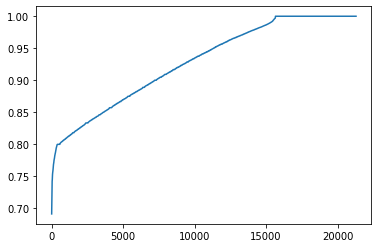

In [ ]:
# mean jacc similarity of the songs belonging to a clique
plot(song_lyrics_cliques_stats[song_lyrics_cliques_stats.n_songs_group>1]['mean'].sort_values().values)

In [ ]:
song_lyrics_cliques_stats[song_lyrics_cliques_stats['mean']<0.75]

,n_songs_group,frac_eval_similarities,mean,std,median,iqr
group_id,,,,,,
2,36.0,0.557143,0.744061,0.118254,0.717391,0.158182
4,46.0,0.574879,0.742894,0.116033,0.725490,0.182937
5,24.0,0.554348,0.691378,0.094977,0.680851,0.137304
9,144.0,0.461636,0.743272,0.098533,0.742424,0.133053
13,13.0,0.358974,0.735619,0.109400,0.725769,0.139159
170,5.0,1.000000,0.742352,0.128672,0.750709,0.177641
217,18.0,0.594771,0.738700,0.129660,0.666667,0.166667
220,9.0,0.277778,0.745406,0.094103,0.758094,0.117691
264,24.0,0.329710,0.729034,0.091748,0.735294,0.138911


### Manual inspect

In [ ]:
song_lyrics_cliques.groupby('group_id').apply(lambda rows: rows.shape[0]).sort_values(ascending=False)[:60]

group_id
9        144
1509     100
6         89
2549      83
1811      54
1741      53
3453      49
4         46
62527     45
4869      44
1309      39
5434      39
3010      37
588       37
3852      37
2         36
4993      35
937       35
3523      35
5310      34
961       34
3065      34
85        33
1268      33
292       33
2564      33
529       32
974       32
114       32
2378      31
3096      31
654       31
5088      31
173       31
446       31
816       31
514       30
2700      30
4761      29
1322      29
4001      29
914       29
353       29
2682      28
490       28
5478      28
5211      27
6865      27
4256      27
1864      27
7893      27
5346      26
752       26
2733      26
394       26
3351      26
1042      26
92        26
2602      25
250       25
dtype: int64

In [ ]:
song_lyrics_cliques[song_lyrics_cliques.group_id==68]

,song_id,song_title,language_detect,lyrics,n_words,n_lines,artist_id,artist_name,song_pubdate_combined,song_year_combined,song_decade_combined,other_artist_info,row,group_id
5426,5714deda25ac0d8aee4979af,Night Time Is The Right Time,english,"You know the night time, darling\n(Night and d...",454,122,56d85f6653a7ddfc01f995ae,Lulu,,1965,1960,"{'n_albums': 15, 'n_songs': 181, 'languages': ...",8694.0,68
12210,5714dec525ac0d8aee39d8db,The Night Time Is The Right Time,english,"You know the night time, darling\n(night and d...",457,122,56d7faa353a7ddfc01f90428,Aretha Franklin,1968-06-14,1968,1960,"{'n_albums': 43, 'n_songs': 583, 'languages': ...",18299.0,68
378802,5714dee125ac0d8aee4efd56,Night Time Is The Right Time,english,"You know the night time, darling\n(night and d...",457,122,56d95eefcc2ddd0c0f6b9e69,Ray Charles,,1960,1960,"{'n_albums': 61, 'n_songs': 993, 'languages': ...",NaN,68
378815,5714dee125ac0d8aee4efd96,Night Time Is The Right Time,english,"You know the night time, darling\n(night and d...",457,122,56d95eefcc2ddd0c0f6b9e69,Ray Charles,,1961,1960,"{'n_albums': 61, 'n_songs': 993, 'languages': ...",NaN,68
403162,5714dee125ac0d8aee4eff31,Night Time Is The Right Time,english,"You know the night time, darling\n(night and d...",457,122,56d95eefcc2ddd0c0f6b9e69,Ray Charles,1994-07-05,1994,1990,"{'n_albums': 61, 'n_songs': 993, 'languages': ...",NaN,68
403192,5714dee125ac0d8aee4eff87,Night Time Is The Right Time,english,"You know the night time, darling\n(night and d...",457,122,56d95eefcc2ddd0c0f6b9e69,Ray Charles,1994-07-05,1994,1990,"{'n_albums': 61, 'n_songs': 993, 'languages': ...",NaN,68
403198,5714dee125ac0d8aee4eff94,Night Time Is The Right Time,english,"You know the night time, darling\n(night and d...",457,122,56d95eefcc2ddd0c0f6b9e69,Ray Charles,1994-07-05,1994,1990,"{'n_albums': 61, 'n_songs': 993, 'languages': ...",NaN,68
